# Simple workflow with twarc

Exploring a simple workflow for docnow:  what does it look like to fetch a sample set of tweets, perform basic analysis, and end up with a summary suitable for non-technical users?

## Setup

We'll start by setting up our environment.  I'm still getting used to writing notebooks intended for audiences broader than either "me" or "my class" so I'll try some new conventions.  I like having python files that follow import grouping and sorting, so let's do that here.

### global imports

In [141]:
from collections import Counter
import json
import os
import sys
import time
from urllib.parse import urlparse

### common imports

In [219]:
%matplotlib inline

from IPython.display import display, Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

### enable ipython autoreloading, as we'll tweak twarc

In [38]:
%load_ext autoreload
%autoreload 1

`%autoreload` is indeed magic.  Read more about it in the [IPython docs](http://ipython.readthedocs.org/en/stable/config/extensions/autoreload.html).  Here it means that anytime a `twarc` function (which we'll import with `%aimport` next) is called, the kernel should reload `twarc` first.  This allows me to change the library in the background and see the changes immediately here.

### local imports

In [206]:
%aimport twarc
import tweepy

We start with establishing an API connection using [twarc](https://github.com/edsu/twarc).  This requires establishing our API key credentials, which I've included in my shell environment, so let's assign them first.

In [40]:
consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN')
access_token_secret = os.environ.get('ACCESS_TOKEN_SECRET')
t = twarc.Twarc(consumer_key=consumer_key, consumer_secret=consumer_secret,
                access_token=access_token, access_token_secret=access_token_secret)

## Fetching tweets using `search()`

Using our ```Twarc``` instance, we can now collect some data.  We'll save a little time by defining a function.

In [43]:
def get_tweets (count=5):
    i = 0
    tweets = []
    for tweet in t.search('lahoreblast', lang='en'):
        i += 1
        if i > count:
            break
        tweets.append(tweet)
    return tweets

In [44]:
tweets = get_tweets(5)
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714488353794580480 - RT @NicoleGLeier: Sending thoughts of love, hope, and peace to the people of Pakistan and all those affected by #LahoreBlast. Our hearts go…
714488352288948225 - RT @Razarumi: .@miqazi shared this terrible image of a the phone of a victim of #LahoreBlast - Caller is Ammi Jan (dear Mom) :( https://t.c…
714488349273161729 - RT @abhijitmajumder: While #LahoreBlast killed children on Easter, Barelvi protesters were burning down one bus station after another in Is…
714488343854202880 - RT @MrsGandhi: Pakistan issues media guidelines after #LahoreBlast,asks to refrain from "crass commercialization" like Indian media https:/…
714488327815229440 - RT @KhaleejMag: Dallas with Lahore https://t.co/uVTVK4sBTa  #PrayForPakistan #LahoreBlast #PrayForLahore #PrayForTheWorld https://t.co/bxGy…


Just to be thorough, let's try that again:

In [45]:
tweets = get_tweets(5)
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714488383423307776 - If ur Religion requires u tO hate someone.....
U must need a New Religion
#LahoreBlast  #nohumanity
714488381720367104 - RT @RT_Erdogan: I strongly condemn the terrorist attack that took place in Lahore yesterday. Turkey stands by Pakistan as it always has bee…
714488373755437056 - RT @zara_hafeez: Please RT: 

#Lahore #LahoreBlast #LahoreAttack #Punjab #Pakistan #Karachi #Islamabad #Peshawar #GulshanIqbalPark https://…
714488367866580992 - Will big monuments light in the colors of #Pakistan's flag tonight? Aren't the victims humans after all?
#LahoreBlast
714488353794580480 - RT @NicoleGLeier: Sending thoughts of love, hope, and peace to the people of Pakistan and all those affected by #LahoreBlast. Our hearts go…


Do you notice how one of the tweets (#714488353794580480, the "@NicoleGLeier" RT) repeats?  This is due to the default behavior of the [search API call](https://dev.twitter.com/rest/reference/get/search/tweets) ```result_type``` option.  By default, it uses `mixed`, which includes a few popular tweets and then recent tweets.

If we change the twarc library (which I've now done under the hood) to accept the `result_type` option, we can explore this more directly.  And let's just look at the IDs to keep it simple.

In [46]:
def get_tweets (count=5, result_type='mixed'):
    i = 0
    tweets = []
    for tweet in t.search('lahoreblast', lang='en', result_type=result_type):
        i += 1
        if i > count:
            break
        tweets.append(tweet)
    return tweets

In [47]:
tweets = get_tweets(5, result_type='popular')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714134717814202368 - The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast
714127906843271168 - Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq
714150230942298112 - Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast
714333047273889792 - I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast
714120753143218177 - It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast


And repeating the same thing to see if the same popular tweets come through:

In [48]:
tweets = get_tweets(5, result_type='popular')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714134717814202368 - The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast
714127906843271168 - Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq
714150230942298112 - Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast
714333047273889792 - I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast
714120753143218177 - It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast


Exactly the same!  Let's try a little more substantial set.

In [64]:
popular1 = set([t['id'] for t in get_tweets(20, result_type='popular')])
popular2 = set([t['id'] for t in get_tweets(20, result_type='popular')])
print('intersection: %s' % len(popular1.intersection(popular2)))
print('difference: %s' % len(popular1.difference(popular2)))

intersection: 16
difference: 0


Okay then, let's try again with `recent`.  We need to "sleep" a little in between request to ensure there's a little time lag between calls, otherwise we'll just get mostly the same tweets again the second time.  Thirty seconds later, the most recent tweets should be new for a big trending tag.

In [67]:
recent1 = set([t['id'] for t in get_tweets(20, result_type='recent')])
# a little delay to allow some new tweets through
time.sleep(30)
recent2 = set([t['id'] for t in get_tweets(20, result_type='recent')])
print('intersection: %s' % len(recent1.intersection(recent2)))
print('difference: %s' % len(recent1.difference(recent2)))

intersection: 0
difference: 20


Works!  [Pull request](https://github.com/edsu/twarc/pull/91) sent. :)

## Counting things:  tags, URLs, mentions, media

Now that we have that settled, let's grab a larger set of tweets and start counting things.

In [56]:
tweets = get_tweets(5, result_type='recent')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714490721693081600 - RT @CBCAlerts: #PopeFrancis calls #LahoreBlast at park on Easter Sunday "vile and senseless." Pontiff urges protection for religious minori…
714490717071138816 - RT @DailyTimes_DT: Islam is a religion of peace #NawazSharif #PMAddress #LahoreBlast #PunjabOperation @pmln_org https://t.co/A4uDs3WPrD htt…
714490712692117504 - RT @Iran: Pres. @HassanRouhani offers condolences after #LahoreBlast 

https://t.co/hIFn8YLFw3

#Iran #Pakistan #NawazSharif https://t.co/c…
714490711211642884 - RT @ARYNEWSOFFICIAL: #ARYBLOG
#Terrorism: A global threat to all regardless of colour
https://t.co/srxk5F8M7c
#LahoreBlast @dr_irfanmalik h…
714490710624378880 - RT @NicoleGLeier: Sending thoughts of love, hope, and peace to the people of Pakistan and all those affected by #LahoreBlast. Our hearts go…


In [70]:
recent_tweets = get_tweets(5000, result_type='recent')

In [71]:
len(recent_tweets)

5000

In [92]:
counter_hashtags = Counter()
for tweet in recent_tweets:
    counter_hashtags.update([hashtag['text'] for hashtag in tweet['entities']['hashtags']
                             if not hashtag['text'].lower() == 'lahoreblast'])

In [123]:
counter_hashtags.most_common(10)

[('Pakistan', 591),
 ('Brussels', 261),
 ('LahoreAttack', 260),
 ('PrayForPakistan', 240),
 ('Lahore', 233),
 ('JeSuisPakistan', 226),
 ('PrayForLahore', 215),
 ('MessagesOfMSG', 123),
 ('NawazSharif', 111),
 ('Punjab', 111)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

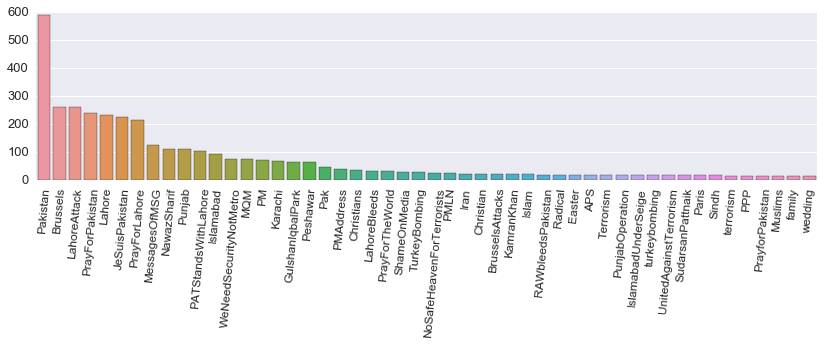

In [127]:
x, y = zip(*counter_hashtags.most_common(50))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=85, fontsize=12)

In [130]:
counter_urls = Counter()
for tweet in recent_tweets:
    counter_urls.update([url['expanded_url'] for url in tweet['entities']['urls']])

In [131]:
counter_urls.most_common(25)

[('https://amp.twimg.com/v/bf1f2d06-2854-4cdf-9646-f39a98d4108d', 237),
 ('https://twitter.com/justintrudeau/status/714150230942298112', 23),
 ('http://bit.ly/1PAI05l', 21),
 ('https://shar.es/1Yen5b', 18),
 ('https://amp.twimg.com/v/8953dab1-779a-4c65-9031-6b6e132d734f', 18),
 ('http://aje.io/vwyr', 18),
 ('http://owl.li/ZZRsr', 15),
 ('http://dailym.ai/1UvrdsX', 15),
 ('http://theiranproject.com/blog/2016/03/28/pres-rouhani-offers-condolences-lahore-blast/',
  15),
 ('https://twitter.com/itsRaniMukerji/status/714446499543969792', 13),
 ('http://twitter.com/planetepics/status/714229685023059968/photo/1', 11),
 ('http://www.siasat.pk/forum/showthread.php?436029-Hassan-Nisar-s-brilliant-analysis-on-yesterday-s-incidents',
  11),
 ('http://n.pr/1pUvysR', 10),
 ('http://aje.io/qbsh', 9),
 ('https://twitter.com/RanaAyyub/status/714112531191562241', 9),
 ('http://aje.io/xyu4', 9),
 ('http://www.bbc.co.uk/programmes/p03ng3fg', 9),
 ('https://twitter.com/omar_quraishi/status/71440472685137920

In [142]:
counter_domains = Counter()
for tweet in recent_tweets:
    counter_domains.update([urlparse(url['expanded_url']).netloc for url in tweet['entities']['urls']])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

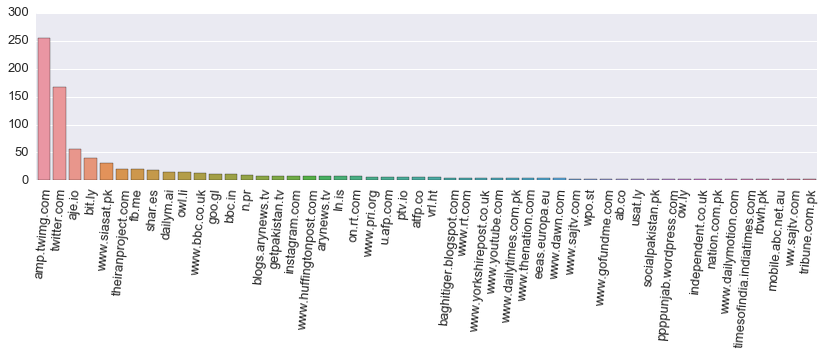

In [151]:
x, y = zip(*counter_domains.most_common(50))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=85, fontsize=13)

In [152]:
counter_mentions = Counter()
for tweet in recent_tweets:
    counter_mentions.update([m['screen_name'] for m in tweet['entities']['user_mentions']])

In [153]:
counter_mentions.most_common(25)

[('INTHENOWRT', 234),
 ('maiolsanauja', 226),
 ('iHrithik', 134),
 ('Gurmeetramrahim', 111),
 ('itsRaniMukerji', 101),
 ('TahirulQadri', 99),
 ('JustinTrudeau', 90),
 ('RT_Erdogan', 76),
 ('ThePakistanArmy', 64),
 ('iHoneyPie', 61),
 ('HassanRouhani', 60),
 ('zara_hafeez', 60),
 ('Ajit_Dobhal', 57),
 ('ianbremmer', 53),
 ('muftimenk', 46),
 ('MalalaFund', 46),
 ('Ali_MuhammadPTI', 46),
 ('Razarumi', 44),
 ('DelhiDragons', 42),
 ('MS_Ali_LEO', 42),
 ('SyedSerendipity', 38),
 ('Xadeejournalist', 37),
 ('The_ashima', 37),
 ('ajmaljami', 36),
 ('AJEnglish', 35)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]), <a list of 75 Text xticklabel objects>)

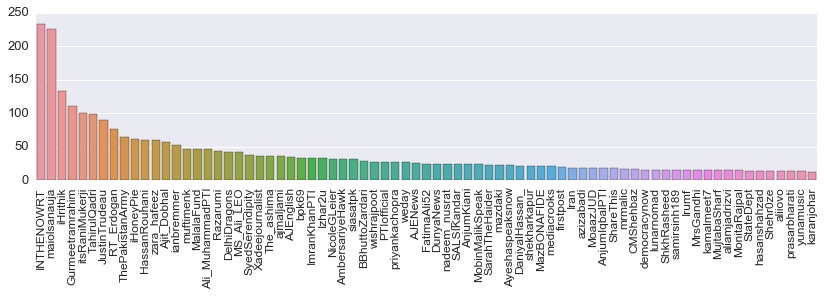

In [158]:
x, y = zip(*counter_mentions.most_common(75))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=90, fontsize=12)

In [160]:
counter_media = Counter()
for tweet in recent_tweets:
    counter_media.update([m['media_url_https'] for m in tweet['entities'].get('media', [])])

In [161]:
counter_media.most_common(25)

[('https://pbs.twimg.com/media/CelRU-pW4AEIM4c.jpg', 225),
 ('https://pbs.twimg.com/media/CepZicMWsAQPkB2.jpg', 65),
 ('https://pbs.twimg.com/media/CepVzMYWwAABqRL.jpg', 60),
 ('https://pbs.twimg.com/media/Ceo9WCZXEAIL_tM.jpg', 53),
 ('https://pbs.twimg.com/media/CekXiwQWAAAwcpO.jpg', 46),
 ('https://pbs.twimg.com/media/Ceo5TdGWsAE8cvi.jpg', 35),
 ('https://pbs.twimg.com/media/CepXxDXWQAAEfVy.jpg', 29),
 ('https://pbs.twimg.com/media/CepZ5GUWwAAFaGI.jpg', 26),
 ('https://pbs.twimg.com/media/Cen61G9WwAApR_m.jpg', 25),
 ('https://pbs.twimg.com/media/CepEDXOWAAQ6-Ip.jpg', 25),
 ('https://pbs.twimg.com/media/CeppNqvXIAEaQjc.jpg', 25),
 ('https://pbs.twimg.com/media/CepIxRMW8AEZgtN.jpg', 24),
 ('https://pbs.twimg.com/media/CepNn_KWwAEVSas.jpg', 21),
 ('https://pbs.twimg.com/media/CepPPLuXEAEleMl.jpg', 21),
 ('https://pbs.twimg.com/media/CeodX5jWQAEJbwS.jpg', 21),
 ('https://pbs.twimg.com/media/CeordU6WEAArWMz.jpg', 20),
 ('https://pbs.twimg.com/media/CepLHs2WIAAxyZY.jpg', 19),
 ('https://pb

In [167]:
images = [Image(url) for url, count in counter_media.most_common(10)]

225 references to https://pbs.twimg.com/media/CelRU-pW4AEIM4c.jpg


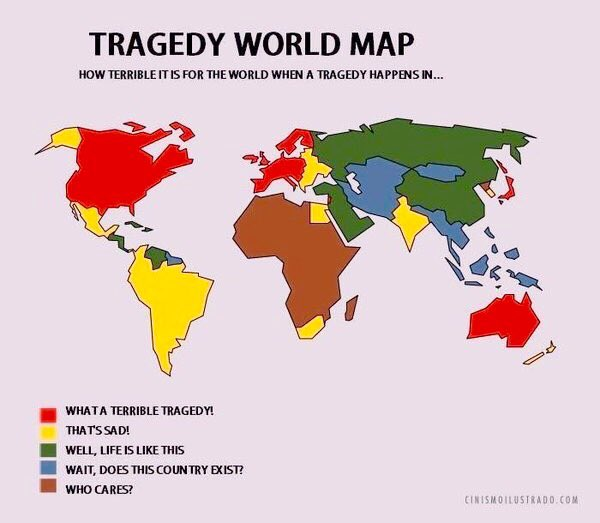

65 references to https://pbs.twimg.com/media/CepZicMWsAQPkB2.jpg


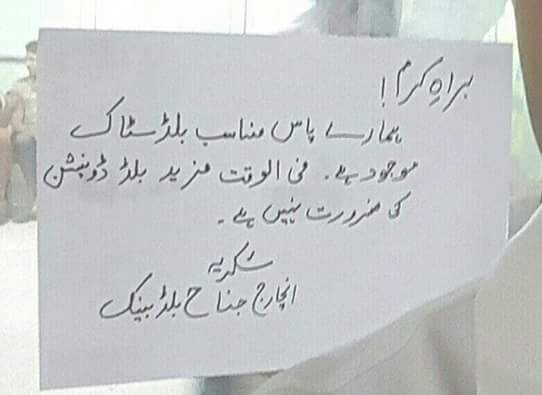

60 references to https://pbs.twimg.com/media/CepVzMYWwAABqRL.jpg


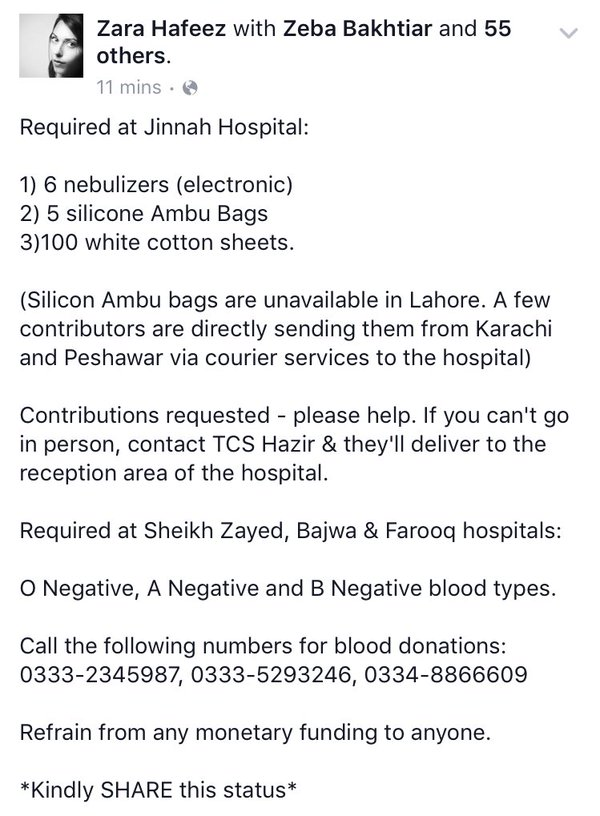

53 references to https://pbs.twimg.com/media/Ceo9WCZXEAIL_tM.jpg


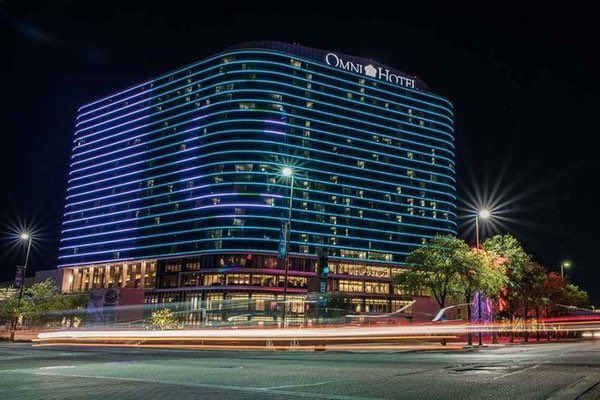

46 references to https://pbs.twimg.com/media/CekXiwQWAAAwcpO.jpg


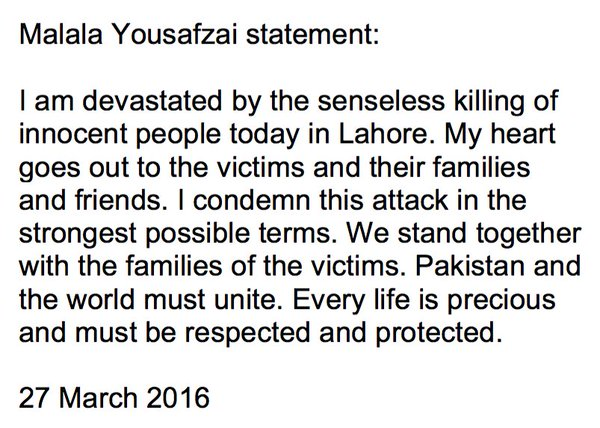

35 references to https://pbs.twimg.com/media/Ceo5TdGWsAE8cvi.jpg


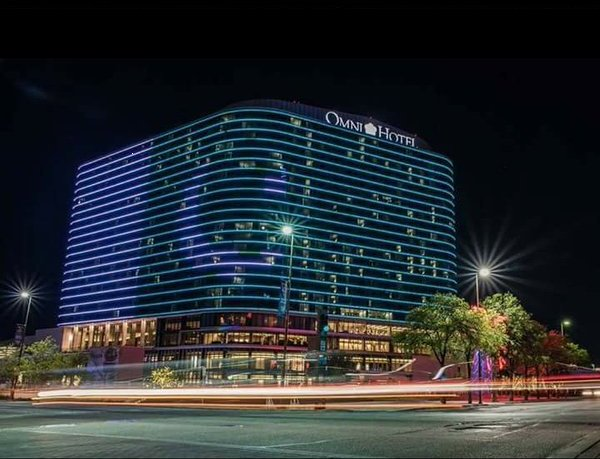

29 references to https://pbs.twimg.com/media/CepXxDXWQAAEfVy.jpg


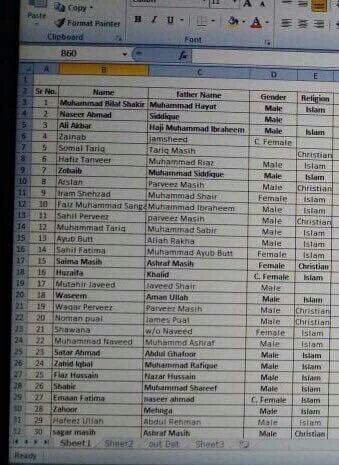

26 references to https://pbs.twimg.com/media/CepZ5GUWwAAFaGI.jpg


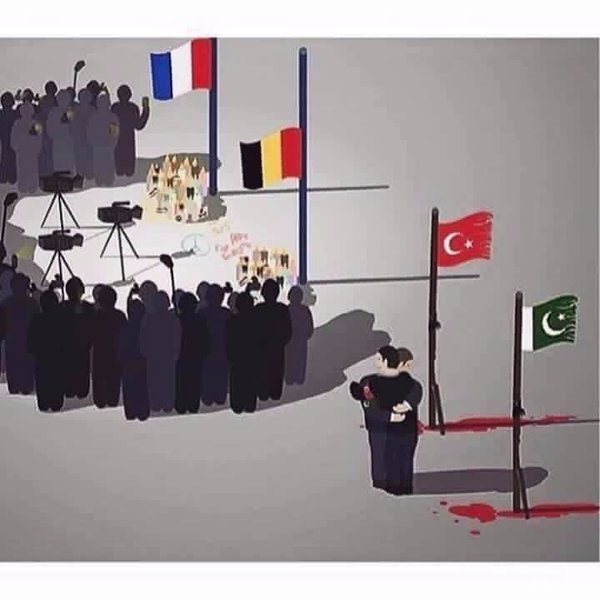

25 references to https://pbs.twimg.com/media/Cen61G9WwAApR_m.jpg


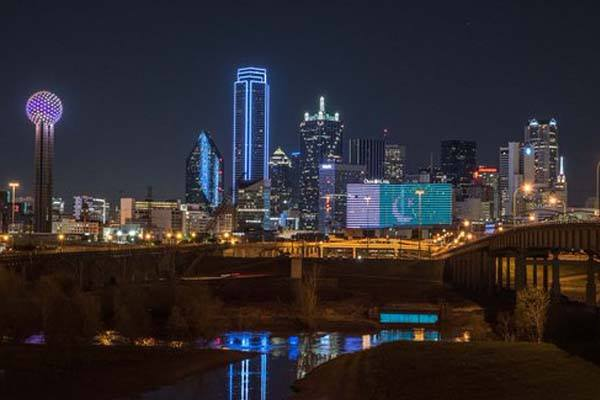

25 references to https://pbs.twimg.com/media/CepEDXOWAAQ6-Ip.jpg


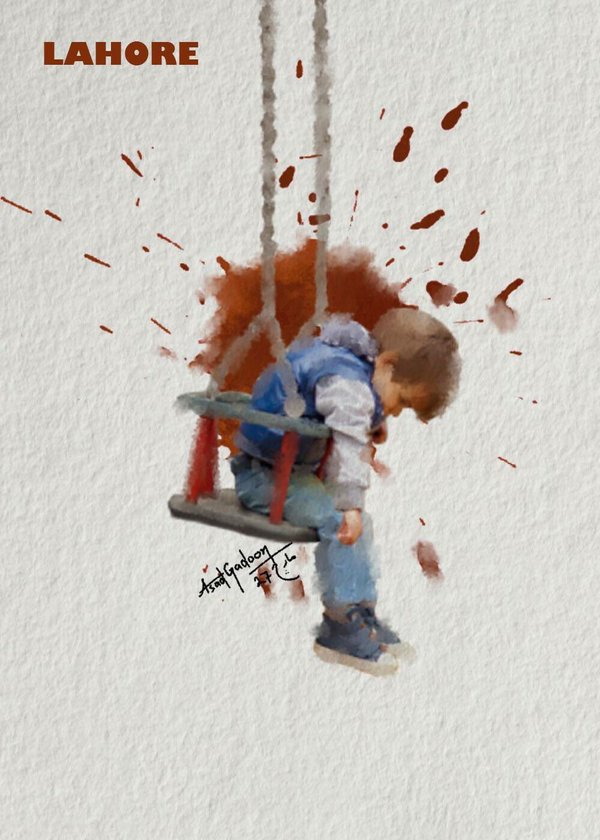

In [181]:
for url, count in counter_media.most_common(10):
    print('%s references to %s' % (count, url))
    display(Image(url))

## Popular tweets and popular mentions

Let's go another level deeper and examine the most popular tweets and the most-mentioned users.  We already have them both in hand:

In [184]:
popular = get_tweets(25, result_type='popular')

In [185]:
[t['text'] for t in popular]

['The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast',
 "Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq",
 'Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast',
 "I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast",
 "It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast",
 'What kind of evil would kill innocent women and children.. this is just pure evil! #PrayForPakistan #LahoreBlast',
 'Saddened and sick to the bone hearing about the #LahoreBlast ..my prayers and deepest sympathies for the families of the lost innocent lives',
 'Sick in the stomach to hear about the #LahoreBlast. What evil people walk this earth that prey on innocent women &amp; children. R.I.P 🙏',
 'Incredible happ

In [186]:
for t in popular:
    u = t['user']
    print('Screen name "%s", name "%s"' % (u['screen_name'], u['name']))

Screen name "priyankachopra", name "PRIYANKA"
Screen name "MalalaFund", name "Malala Fund"
Screen name "JustinTrudeau", name "Justin Trudeau"
Screen name "iHrithik", name "Hrithik Roshan"
Screen name "TheMahiraKhan", name "Mahira Khan"
Screen name "yunamusic", name "Yuna Zarai"
Screen name "karanjohar", name "Karan Johar"
Screen name "realpreityzinta", name "Preity zinta"
Screen name "Riteishd", name "Riteish Deshmukh"
Screen name "shekharkapur", name "Shekhar Kapur"
Screen name "ayushmannk", name "Ayushmann Khurrana"
Screen name "irrfan_k", name "irrfan"
Screen name "BBCBreaking", name "BBC Breaking News"
Screen name "RT_Erdogan", name "Recep Tayyip Erdoğan"
Screen name "M_IrfanOfficial", name "Mohammad Irfan"
Screen name "SAMAATV", name "SAMAA TV"


In [204]:
popular_screen_names = set([t['user']['screen_name'] for t in popular])
screen_names, counts = zip(*counter_mentions.most_common(1000))
common_mentions = set(screen_names)

All of the following screen names are both *authors* of popular tweets and *mentions* of many other users.

In [202]:
popular_screen_names.intersection(common_mentions)

{'BBCBreaking',
 'JustinTrudeau',
 'MalalaFund',
 'RT_Erdogan',
 'Riteishd',
 'TheMahiraKhan',
 'ayushmannk',
 'iHrithik',
 'irrfan_k',
 'karanjohar',
 'priyankachopra',
 'shekharkapur',
 'yunamusic'}

But these remaining few are authors of popular tweets but not as commonly mentioned.

In [203]:
popular_screen_names.difference(common_mentions)

{'M_IrfanOfficial', 'SAMAATV', 'realpreityzinta'}

Let's take a closer look at the follow/follower counts of these two sets of users.  We should be able to pull the key data out from the tweets we already have.

In [205]:
for t in popular:
    u = t['user']
    print('%s (%s): %s followers, following %s' % (u['screen_name'], u['name'],
                                                   u['followers_count'], u['friends_count']))

priyankachopra (PRIYANKA): 13345695 followers, following 480
MalalaFund (Malala Fund): 425002 followers, following 448
JustinTrudeau (Justin Trudeau): 1528025 followers, following 925
iHrithik (Hrithik Roshan): 13394845 followers, following 113
TheMahiraKhan (Mahira Khan): 141778 followers, following 72
yunamusic (Yuna Zarai): 1473128 followers, following 1015
karanjohar (Karan Johar): 8356855 followers, following 389
realpreityzinta (Preity zinta): 4039080 followers, following 73
Riteishd (Riteish Deshmukh): 4878333 followers, following 248
shekharkapur (Shekhar Kapur): 1554704 followers, following 370
ayushmannk (Ayushmann Khurrana): 2720882 followers, following 301
irrfan_k (irrfan): 713933 followers, following 222
BBCBreaking (BBC Breaking News): 21836226 followers, following 3
RT_Erdogan (Recep Tayyip Erdoğan): 8123341 followers, following 2
M_IrfanOfficial (Mohammad Irfan): 38314 followers, following 79
SAMAATV (SAMAA TV): 381024 followers, following 40


Tweepy has [handy methods for collecting friend/follower](http://tweepy.readthedocs.org/en/v3.5.0/api.html#API.friends_ids) info for given users.  Let's pull that in and construct a network of who these popular twitterers are following.

In [207]:
import tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [323]:
follow_net = []
user_set = set()
for user in [t['user'] for t in popular]:
    print('Fetching users for %s' % user['screen_name'])
    time.sleep(120)
    user_id = user['id']
    follows = api.friends_ids(user_id)
    follow_net.append((user_id, follows))
    user_set.update(follows)

Fetching users for priyankachopra
Fetching users for MalalaFund
Fetching users for JustinTrudeau
Fetching users for iHrithik
Fetching users for TheMahiraKhan
Fetching users for yunamusic
Fetching users for karanjohar
Fetching users for realpreityzinta
Fetching users for Riteishd
Fetching users for shekharkapur
Fetching users for ayushmannk
Fetching users for irrfan_k
Fetching users for BBCBreaking
Fetching users for RT_Erdogan
Fetching users for M_IrfanOfficial
Fetching users for SAMAATV


Unfortunately the rate limiting on that function call is severe: 15 calls every 15 minutes.  When debugging, you run into that quickly!

Oh well, we got enough data to move forward some.  First, let's see how much overlap there might be by checking the overall set against the complete count of each following list.

In [324]:
[x for x, y in follow_net]

[18681139,
 1581289837,
 14260960,
 113419517,
 412681753,
 121199319,
 57928790,
 86254626,
 57998991,
 15093629,
 38403110,
 490442018,
 5402612,
 68034431,
 3233992591,
 22127823]

In [325]:
len(user_set)

4080

In [326]:
sum([len(ids) for u, ids in follow_net])

4780

That's already a significant difference.  The graph should show this clearly.

In [371]:
g = nx.Graph()
for user_id, friends_ids in follow_net:
    for friend_id in friends_ids:
        g.add_edge(str(user_id), str(friend_id))

In [381]:
sg = nx.Graph()
popular_ids = [t['user']['id'] for t in popular]
for node in sorted(g.nodes()):
    if node in [str(i) for i in popular_ids]:
        continue
    if len(g.edges(node)) > 3:
       sg.add_edges_from(g.edges(node))

In [382]:
labels = {}
follow_net_users = [x for x, y in follow_net]
for u in [t['user'] for t in popular]:
    if u['id'] in follow_net_users:
        labels[str(u['id'])] = u['screen_name']

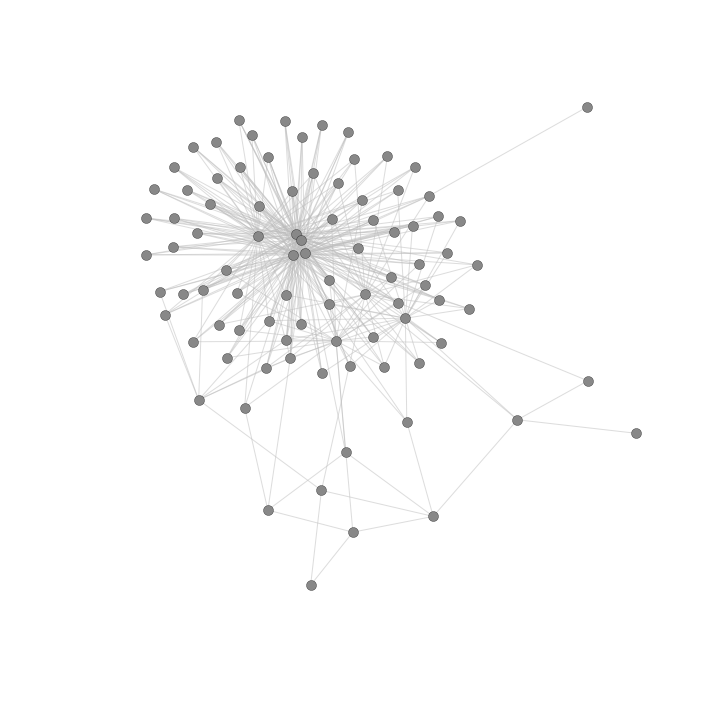

In [386]:
plt.figure(figsize=(12, 12))
pos = nx.fruchterman_reingold_layout(sg)
nx.draw_networkx_nodes(sg, pos, node_size=100, node_color='#888888')
nx.draw_networkx_edges(sg, pos, edge_color='#bbbbbb',
                 arrows=False, alpha=0.5)
#nx.draw_networkx_labels(sg, pos, labels, fontsize=18)
plt.axis('off')
plt.show()